Importing necessary libraries

In [1]:
import datetime as dt
import numpy as np
import pandas as pd

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

import matplotlib.pyplot as plt
import matplotlib.dates as m_dates

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit

%matplotlib inline

Loading sample dataset for visualization

In [3]:
dataset = pd.read_csv(
    filepath_or_buffer='https://raw.githubusercontent.com/Patryk0990/biai-stock-market/main/DATA/three_years/AAPL.csv', 
    index_col='Date')

dates_str = [dt.datetime.strptime(d, '%Y-%m-%d').date() for d in dataset.index.values]

dataset.head()


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,73.449402,135480400
2020-01-03,74.287498,75.144997,74.125000,74.357498,72.735313,146322800
2020-01-06,73.447502,74.989998,73.187500,74.949997,73.314880,118387200
2020-01-07,74.959999,75.224998,74.370003,74.597504,72.970093,108872000
2020-01-08,74.290001,76.110001,74.290001,75.797501,74.143890,132079200


Corelation between stock metrics

C:\Users\patro\AppData\Local\Temp\ipykernel_21996\4139901338.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 2, 1)


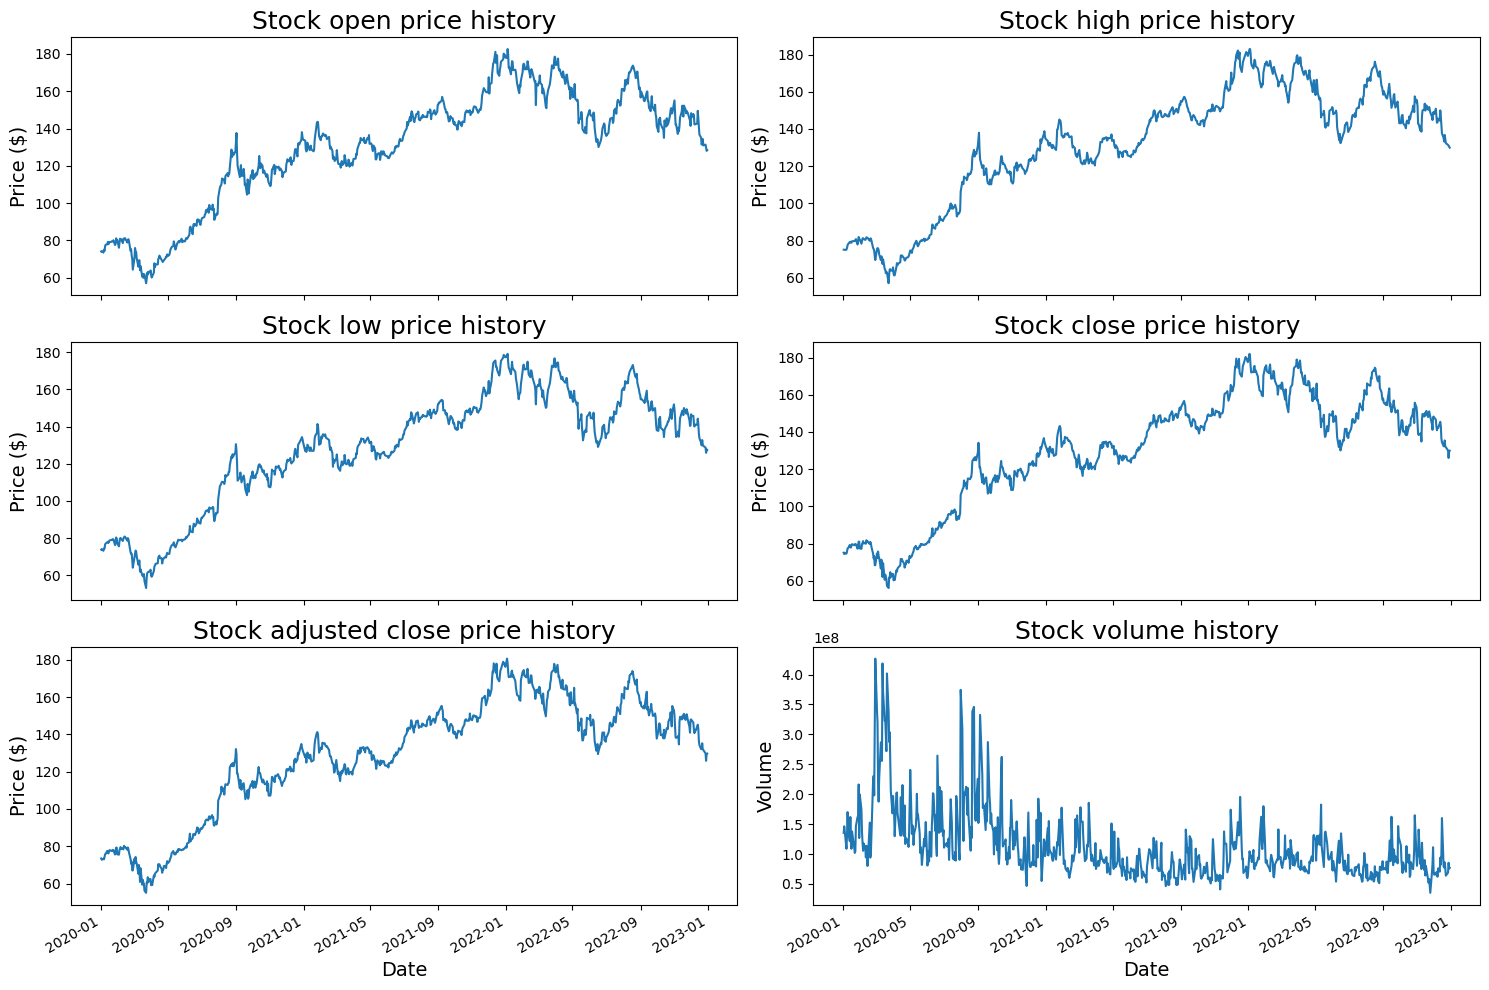

In [11]:
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)
plt.gca().xaxis.set_major_formatter(m_dates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(m_dates.DayLocator(interval=90))

# Open price
plt.subplot(3, 2, 1)
plt.title('Stock open price history', fontsize=18)
plt.plot(dates_str, dataset['Open'])
plt.ylabel('Price ($)', fontsize=14)

# High price
plt.subplot(3, 2, 2)
plt.title('Stock high price history', fontsize=18)
plt.plot(dates_str, dataset['High'])
plt.ylabel('Price ($)', fontsize=14)

# low price
plt.subplot(3, 2, 3)
plt.title('Stock low price history', fontsize=18)
plt.plot(dates_str, dataset['Low'])
plt.ylabel('Price ($)', fontsize=14)

# Close price
plt.subplot(3, 2, 4)
plt.title('Stock close price history', fontsize=18)
plt.plot(dates_str, dataset['Close'])
plt.ylabel('Price ($)', fontsize=14)

# Adjusted close price
plt.subplot(3, 2, 5)
plt.title('Stock adjusted close price history', fontsize=18)
plt.plot(dates_str, dataset['Adj Close'])
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price ($)', fontsize=14)

# Volume
plt.subplot(3, 2, 6)
plt.title('Stock volume history', fontsize=18)
plt.plot(dates_str, dataset['Volume'])
plt.xlabel('Date', fontsize=14)
plt.ylabel('Volume', fontsize=14)

plt.gcf().autofmt_xdate()
plt.tight_layout()

EMA vs SMA

Moving average indicators are supposed to show trends in grow direction of price. Value is based on the previous intervals and because of it, has some delayed reaction to changes on the market. SMA tends to have lower sensitivity to changes and has more shift lags. According to this, traders tend to use EMA more than SMA.

Visualization of EMA and SMA short term indicators (26 days)

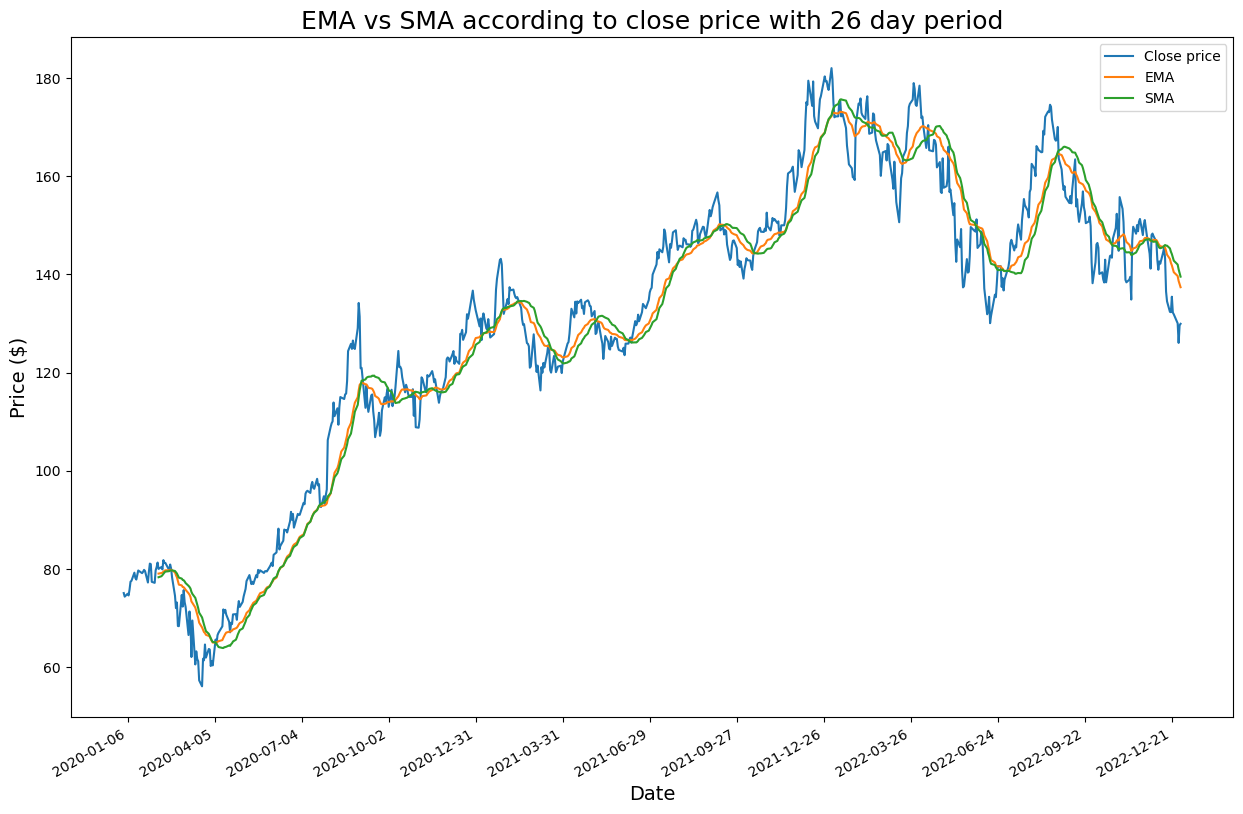

In [12]:
ema = dataset['Close'].ewm(span=26, min_periods=26).mean()
sma = dataset['Close'].rolling(26).mean()

plt.figure(figsize=(15, 10))
plt.gca().xaxis.set_major_formatter(m_dates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(m_dates.DayLocator(interval=90))

plt.title('EMA vs SMA according to close price with 26 day period', fontsize=18)
plt.plot(dates_str, dataset['Close'], label='Close price')
plt.plot(dates_str, ema, label='EMA')
plt.plot(dates_str, sma, label='SMA')

plt.xlabel('Date', fontsize=14)
plt.ylabel('Price ($)', fontsize=14)

plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

Comparing EMA with different periods

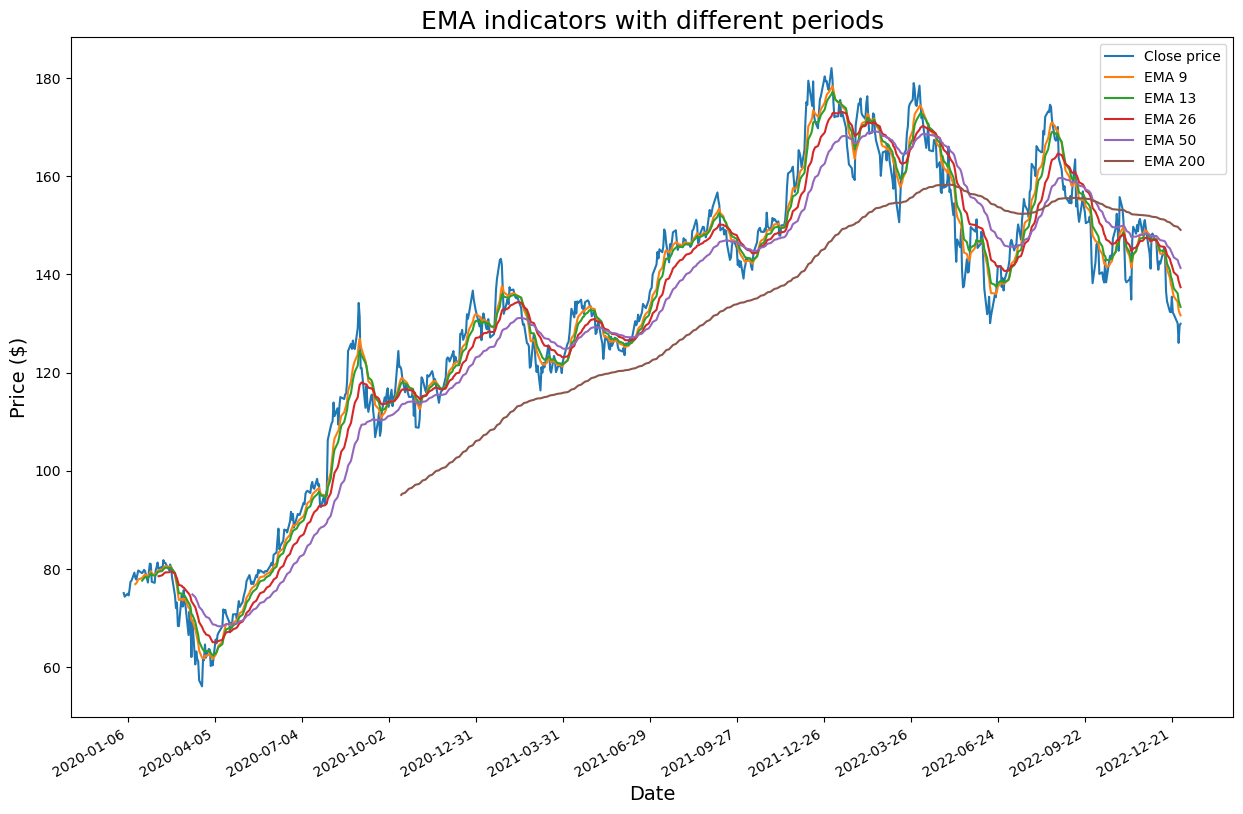

In [13]:
ema_9 = dataset['Close'].ewm(span=9, min_periods=9, adjust=False).mean()
ema_13 = dataset['Close'].ewm(span=13, min_periods=13, adjust=False).mean()
ema_26 = dataset['Close'].ewm(span=26, min_periods=26, adjust=False).mean()
ema_50 = dataset['Close'].ewm(span=50, min_periods=50, adjust=False).mean()
ema_200 = dataset['Close'].ewm(span=200, min_periods=200, adjust=False).mean()

plt.figure(figsize=(15, 10))
plt.gca().xaxis.set_major_formatter(m_dates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(m_dates.DayLocator(interval=90))

plt.title('EMA indicators with different periods', fontsize=18)
plt.plot(dates_str, dataset['Close'], label='Close price')
plt.plot(dates_str, ema_9, label='EMA 9')
plt.plot(dates_str, ema_13, label='EMA 13')
plt.plot(dates_str, ema_26, label='EMA 26')
plt.plot(dates_str, ema_50, label='EMA 50')
plt.plot(dates_str, ema_200, label='EMA 200')

plt.xlabel('Date', fontsize=14)
plt.ylabel('Price ($)', fontsize=14)

plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

Moving Average Convergence Divergence (MACD) is one of the most popular technical indicators used to generate signals to buy or sell shares wherease the value of the difference indicator stays above or under the value of 0.

To create MACD we need to implement three "signals". 

First one, mostly known as MACD represents substracted value of EMA with long lookback period from EMA with short lookback period. In our example it's EMA 13 and EMA 26.
Second one is trigger signal which is respresented by EMA with shorter lookback period than the one used in MACD signal. Typically it's EMA 9.
The last one is difference signal which is basically subtracted value of trigger signal from the MACD signal.

Visualization of MACD

C:\Users\patro\AppData\Local\Temp\ipykernel_21996\1444963542.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 1, 1)


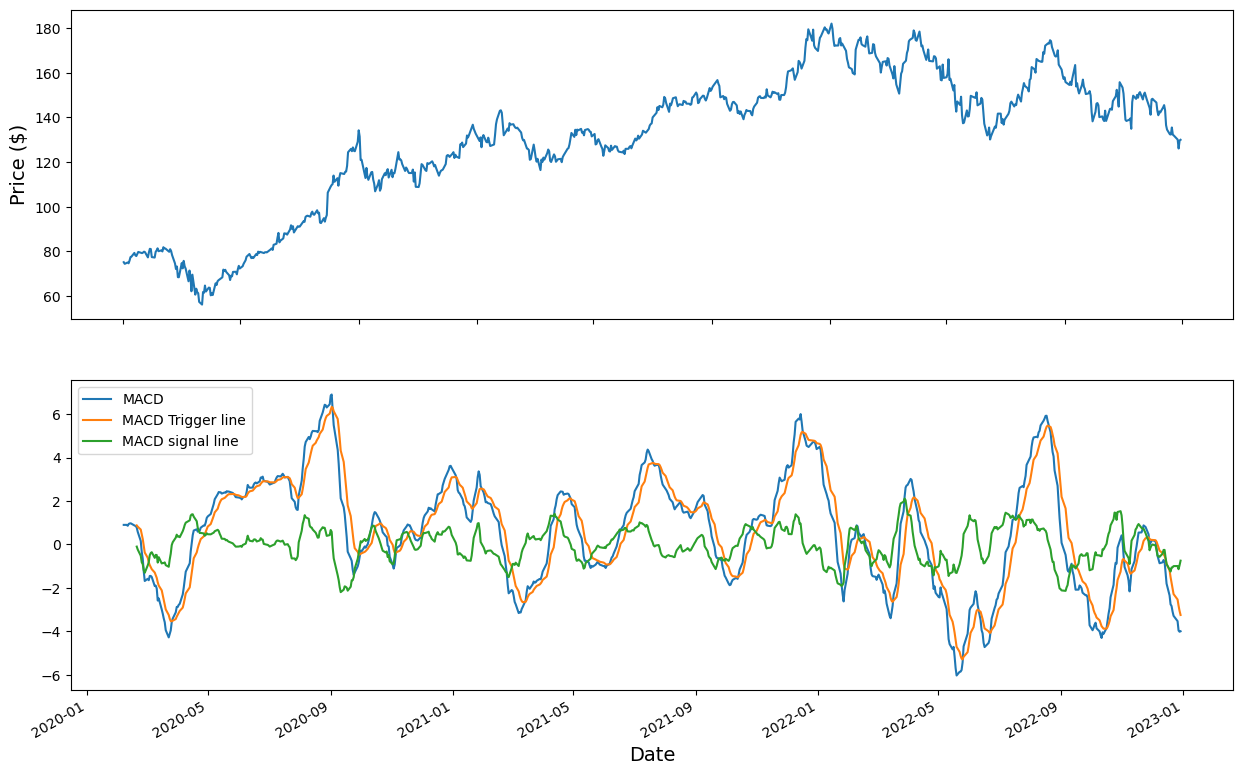

In [14]:
macd = ema_13 - ema_26
macd_trigger = macd.ewm(span=9, min_periods=9, adjust=False).mean()
macd_difference = macd - macd_trigger

plt.figure(figsize=(15, 10))
plt.gca().xaxis.set_major_formatter(m_dates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(m_dates.DayLocator(interval=90))
plt.title('MACD', fontsize=18)

plt.subplot(2, 1, 1)
plt.plot(dates_str, dataset['Close'], label='Close price')
plt.ylabel('Price ($)', fontsize=14)

plt.subplot(2, 1, 2)
plt.plot(dates_str, macd, label='MACD')
plt.plot(dates_str, macd_trigger, label='MACD Trigger line')
plt.plot(dates_str, macd_difference, label='MACD signal line')

plt.xlabel('Date', fontsize=14)
plt.gcf().autofmt_xdate()

plt.legend()
plt.show()

Relative Strength Index is a momentum indicator that represents magnitude of recent price changes. 
It's mostly known for evaluation of either overbought or oversold conditions of shares.
It takes value from 0 to 100. 
For indication of overbought or oversold signals mostly common trend lines take values of 60/40 or 70/30. Depending on intentions of the trader. One gives more opportunities but with less presumable profit and other gives less opportunities but with more likely profit.

Visualization of RSI

C:\Users\patro\AppData\Local\Temp\ipykernel_21996\1267040693.py:13: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 1, 1)


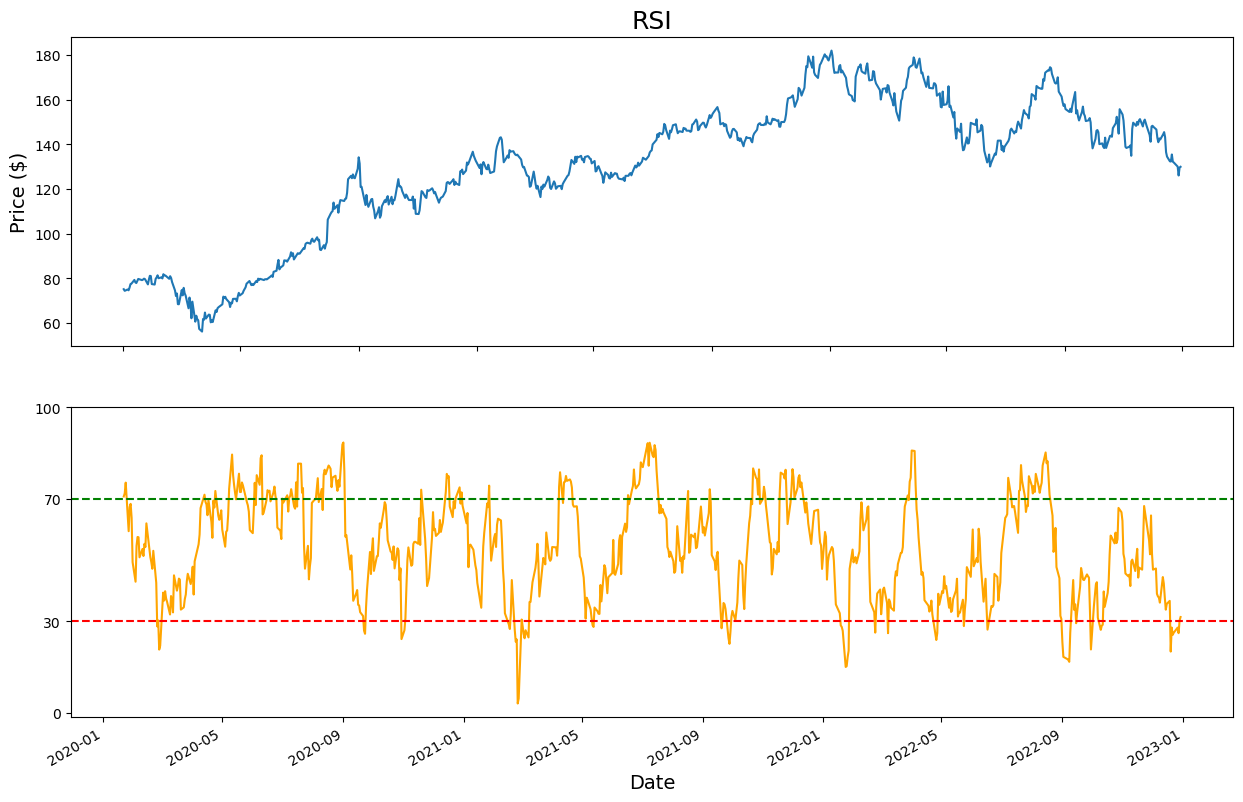

In [15]:
delta = dataset['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14, min_periods=14).mean()
avg_loss = loss.rolling(window=14, min_periods=14).mean().abs()
rs = avg_gain / avg_loss
rsi = 100 - (100 / (1 + rs))

plt.figure(figsize=(15, 10))
plt.gca().xaxis.set_major_formatter(m_dates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(m_dates.DayLocator(interval=90))

plt.subplot(2, 1, 1)
plt.title('RSI', fontsize=18)
plt.plot(dates_str, dataset['Close'], label='Close price')
plt.ylabel('Price ($)', fontsize=14)

plt.subplot(2, 1, 2)
plt.plot(dates_str, rsi, label='RSI', color='orange')
plt.axhline(y=30, color='red', linestyle='--')
plt.axhline(y=70, color='green', linestyle='--')
plt.yticks([0, 30, 70, 100])

plt.xlabel('Date', fontsize=14)
plt.gcf().autofmt_xdate()

plt.show()

Training datasaet based on 10 previous stock price

In [13]:
dataset = pd.read_csv(
    filepath_or_buffer='https://raw.githubusercontent.com/Patryk0990/biai-stock-market/main/DATA/historical/AAPL.csv', 
    index_col='Date')

close_price_values = dataset.filter(['Close']).values
scaler = MinMaxScaler(feature_range=(0, 1))
train_data = scaler.fit_transform(close_price_values)

x_train = []
y_train = []

for index in range(10, len(train_data)):
    x_train.append(train_data[index-10:index, 0])
    y_train.append(train_data[index, 0])

# Convert trainset to array and reshape x_train data    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


In [14]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Default LSTM model
lstm = Sequential(
    layers=[
        LSTM(512, return_sequences=True, input_shape=(x_train.shape[1], 1)),
        LSTM(256),
        Dense(1)
    ]
)
lstm.compile(optimizer='adam', loss='mean_squared_error')
lstm.fit(x_train, y_train, batch_size=256, epochs=100)

# LSTM model with dropout layers
lstm_2 = Sequential(
    layers=[
        LSTM(512, return_sequences=True, input_shape=(x_train.shape[1], 1)),
        Dropout(0.2),
        LSTM(256),        
        Dropout(0.2),
        Dense(1)
    ]
)
lstm_2.compile(optimizer='adam', loss='mean_squared_error')
lstm_2.fit(x_train, y_train, batch_size=256, epochs=100)

# LSTM model with dropout layers and additional dense layer
lstm_3 = Sequential(
    layers=[
        LSTM(512, return_sequences=True, input_shape=(x_train.shape[1], 1)),
        Dropout(0.2),
        LSTM(256),        
        Dropout(0.2),
        Dense(10),
        Dense(1)
    ]
)
lstm_3.compile(optimizer='adam', loss='mean_squared_error')
lstm_3.fit(x_train, y_train, batch_size=256, epochs=100)

# LSTM model with additional LSTM layer
lstm_4 = Sequential(
    layers=[
        LSTM(512, return_sequences=True, input_shape=(x_train.shape[1], 1)),
        LSTM(256, return_sequences=True),
        LSTM(128),
        Dense(1)
    ]
)
lstm_4.compile(optimizer='adam', loss='mean_squared_error')
lstm_4.fit(x_train, y_train, batch_size=256, epochs=100)

# LSTM model with additional LSTM layer, dropout layers
lstm_5 = Sequential(
    layers=[
        LSTM(512, return_sequences=True, input_shape=(x_train.shape[1], 1)),
        Dropout(0.2),
        LSTM(256, return_sequences=True),
        Dropout(0.2),
        LSTM(128),
        Dropout(0.2),
        Dense(1)
    ]
)
lstm_5.compile(optimizer='adam', loss='mean_squared_error')
lstm_5.fit(x_train, y_train, batch_size=256, epochs=100)

# LSTM model with additional LSTM layer, dropout layers and additional dense layer
lstm_6 = Sequential(
    layers=[
        LSTM(512, return_sequences=True, input_shape=(x_train.shape[1], 1)),
        Dropout(0.2),
        LSTM(256, return_sequences=True),
        Dropout(0.2),
        LSTM(128),
        Dropout(0.2),
        Dense(10),
        Dense(1)
    ]
)
lstm_6.compile(optimizer='adam', loss='mean_squared_error')
lstm_6.fit(x_train, y_train, batch_size=256, epochs=100)


Epoch 1/100
42/42 [==============================] - 8s 157ms/step - loss: 0.0027
Epoch 2/100
42/42 [==============================] - 7s 159ms/step - loss: 7.1477e-05
Epoch 3/100
42/42 [==============================] - 7s 157ms/step - loss: 6.0398e-05
Epoch 4/100
42/42 [==============================] - 7s 156ms/step - loss: 6.6284e-05
Epoch 5/100
42/42 [==============================] - 7s 156ms/step - loss: 6.0604e-05
Epoch 6/100
42/42 [==============================] - 7s 157ms/step - loss: 5.8386e-05
Epoch 7/100
42/42 [==============================] - 7s 158ms/step - loss: 7.8871e-05
Epoch 8/100
42/42 [==============================] - 7s 158ms/step - loss: 6.5432e-05
Epoch 9/100
42/42 [==============================] - 7s 158ms/step - loss: 7.1254e-05
Epoch 10/100
42/42 [==============================] - 7s 158ms/step - loss: 5.6814e-05
Epoch 11/100
42/42 [==============================] - 7s 159ms/step - loss: 5.9038e-05
Epoch 12/100
42/42 [==============================] - 7s

Prepare test dataset

In [15]:
test_dataset = pd.read_csv(
    filepath_or_buffer='https://raw.githubusercontent.com/Patryk0990/biai-stock-market/main/DATA/three_years/MSFT.csv', 
    index_col='Date')
test_dates_str = [dt.datetime.strptime(d, '%Y-%m-%d').date() for d in test_dataset.index.values]

test_price = test_dataset.filter(['Close'])
scaler = MinMaxScaler(feature_range=(0, 1))
test_data = scaler.fit_transform(test_price.values)

x_test = []
y_test = test_price.values[10:len(test_data), :]

for index in range(10, len(test_data)):
    x_test.append(test_data[index-10:index, 0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

Test output RMSE

In [16]:
predictions = lstm.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse=np.sqrt(np.mean((predictions - y_test) ** 2))
print(f'Default model RMSE: {rmse}')

predictions_2 = lstm_2.predict(x_test)
predictions_2 = scaler.inverse_transform(predictions_2)
rmse_2=np.sqrt(np.mean((predictions_2 - y_test) ** 2))
print(f'Model with dropout layers RMSE: {rmse_2}')

predictions_3 = lstm_3.predict(x_test)
predictions_3 = scaler.inverse_transform(predictions_3)
rmse_3=np.sqrt(np.mean((predictions_3 - y_test) ** 2))
print(f'Model with additional dense, dropout layers RMSE: {rmse_3}')

predictions_4 = lstm_4.predict(x_test)
predictions_4 = scaler.inverse_transform(predictions_4)
rmse_4=np.sqrt(np.mean((predictions_4 - y_test) ** 2))
print(f'Model with additional LSTM layer RMSE: {rmse_4}')

predictions_5 = lstm_5.predict(x_test)
predictions_5 = scaler.inverse_transform(predictions_5)
rmse_5=np.sqrt(np.mean((predictions_5 - y_test) ** 2))
print(f'Model with additional LSTM, dropout layers RMSE: {rmse_5}')

predictions_6 = lstm_6.predict(x_test)
predictions_6 = scaler.inverse_transform(predictions_6)
rmse_6=np.sqrt(np.mean((predictions_6 - y_test) ** 2))
print(f'Model with additional LSTM and dense, dropout layers RMSE: {rmse_6}')


24/24 [==============================] - 1s 21ms/step
Default model RMSE: 5.115447304890235
24/24 [==============================] - 1s 20ms/step
Model with dropout layers RMSE: 5.551426500222034
24/24 [==============================] - 1s 21ms/step
Model with additional dense, dropout layers RMSE: 5.862157263279812
24/24 [==============================] - 1s 23ms/step
Model with additional LSTM layer RMSE: 4.825531329114918
24/24 [==============================] - 1s 22ms/step
Model with additional LSTM, dropout layers RMSE: 5.598058541048898
24/24 [==============================] - 1s 23ms/step
Model with additional LSTM and dense, dropout layers RMSE: 6.127154677104754


Test output visualization

C:\Users\patro\AppData\Local\Temp\ipykernel_19240\1022477186.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 2, 1)


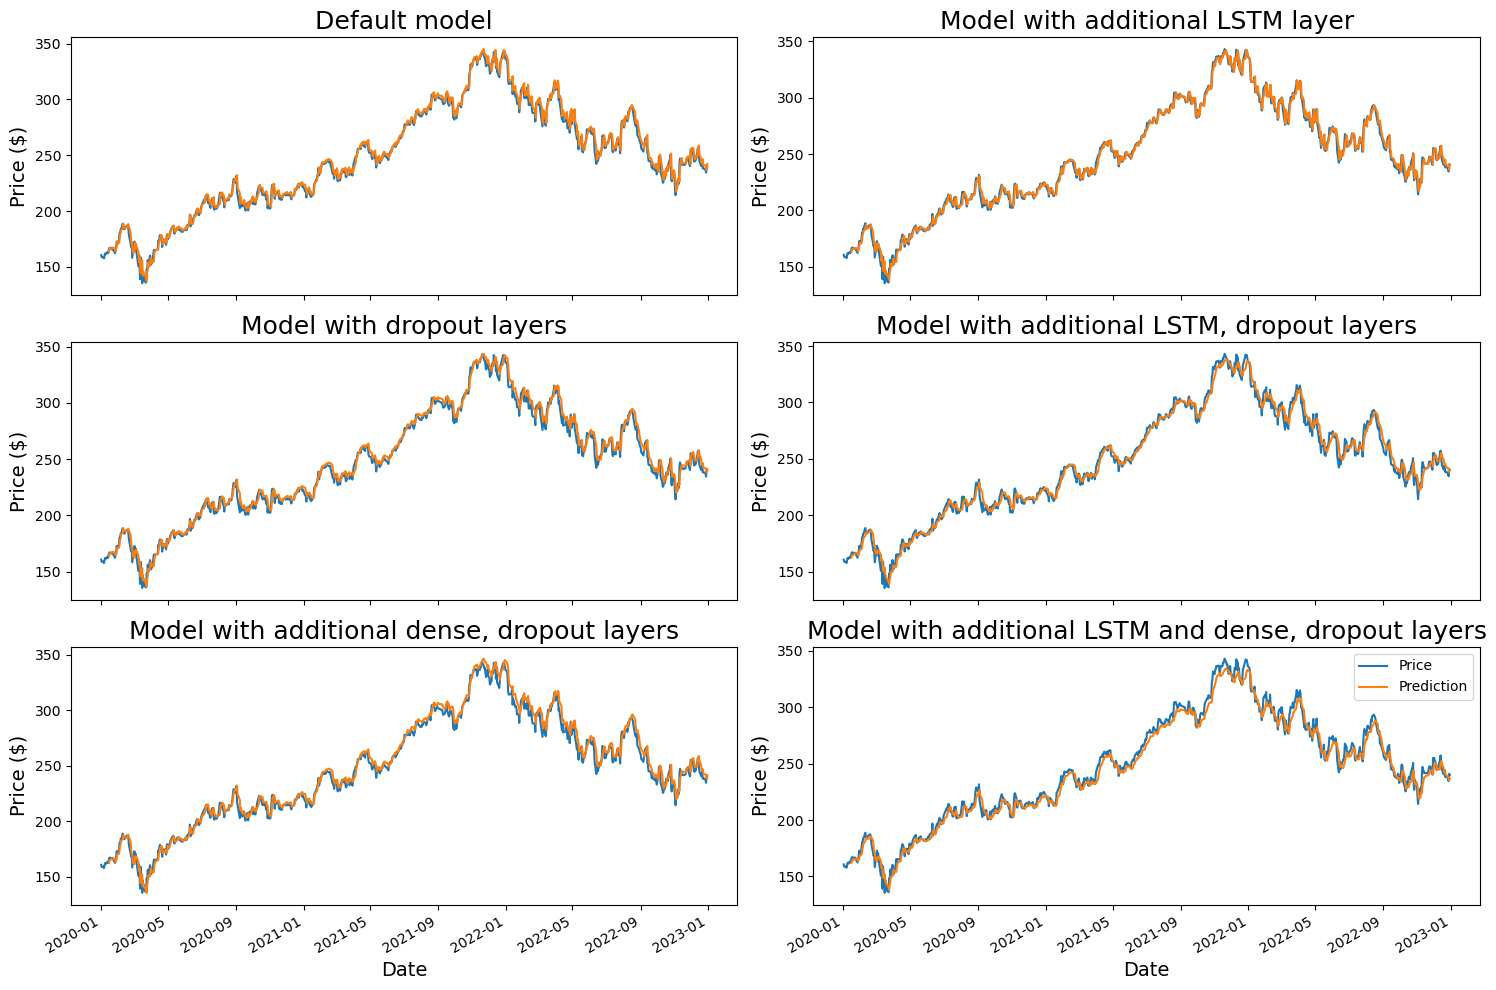

In [17]:
# Visualize the data
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)
plt.gca().xaxis.set_major_formatter(m_dates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(m_dates.DayLocator(interval=90))

# Open price
plt.subplot(3, 2, 1)
plt.title('Default model', fontsize=18)
plt.plot(test_dates_str, test_price['Close'], label='Price')
plt.plot(test_dates_str[10:], predictions, label='Prediction')
plt.ylabel('Price ($)', fontsize=14)

# High price
plt.subplot(3, 2, 2)
plt.title('Model with additional LSTM layer', fontsize=18)
plt.plot(test_dates_str, test_price['Close'], label='Price')
plt.plot(test_dates_str[10:], predictions_4, label='Prediction')
plt.ylabel('Price ($)', fontsize=14)

# low price
plt.subplot(3, 2, 3)
plt.title('Model with dropout layers', fontsize=18)
plt.plot(test_dates_str, test_price['Close'], label='Price')
plt.plot(test_dates_str[10:], predictions_2, label='Prediction')
plt.ylabel('Price ($)', fontsize=14)

# Close price
plt.subplot(3, 2, 4)
plt.title('Model with additional LSTM, dropout layers', fontsize=18)
plt.plot(test_dates_str, test_price['Close'], label='Price')
plt.plot(test_dates_str[10:], predictions_5, label='Prediction')
plt.ylabel('Price ($)', fontsize=14)

# Adjusted close price
plt.subplot(3, 2, 5)
plt.title('Model with additional dense, dropout layers', fontsize=18)
plt.plot(test_dates_str, test_price['Close'], label='Price')
plt.plot(test_dates_str[10:], predictions_3, label='Prediction')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price ($)', fontsize=14)

# Volume
plt.subplot(3, 2, 6)
plt.title('Model with additional LSTM and dense, dropout layers', fontsize=18)
plt.plot(test_dates_str, test_price['Close'], label='Price')
plt.plot(test_dates_str[10:], predictions_6, label='Prediction')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price ($)', fontsize=14)

plt.legend()
plt.gcf().autofmt_xdate()
plt.tight_layout()

Futher improvements

In [18]:
# LSTM model with additional LSTM layer
lstm_4 = Sequential(
    layers=[
        LSTM(512, return_sequences=True, input_shape=(x_train.shape[1], 1)),
        LSTM(256, return_sequences=True),
        LSTM(128),
        Dense(25),
        Dense(1)
    ]
)
lstm_4.compile(optimizer='adam', loss='mean_squared_error')
lstm_4.fit(x_train, y_train, batch_size=256, epochs=500)

predictions_4 = lstm_4.predict(x_test)
predictions_4 = scaler.inverse_transform(predictions_4)
rmse_4=np.sqrt(np.mean((predictions_4 - y_test) ** 2))
print(f'Model with additional LSTM layer RMSE: {rmse_4}')

Epoch 1/500
42/42 [==============================] - 12s 209ms/step - loss: 0.0027
Epoch 2/500
42/42 [==============================] - 10s 237ms/step - loss: 9.8896e-05
Epoch 3/500
42/42 [==============================] - 10s 238ms/step - loss: 9.8203e-05
Epoch 4/500
42/42 [==============================] - 9s 223ms/step - loss: 8.6873e-05
Epoch 5/500
42/42 [==============================] - 9s 218ms/step - loss: 8.9026e-05
Epoch 6/500
42/42 [==============================] - 9s 217ms/step - loss: 1.1720e-04
Epoch 7/500
42/42 [==============================] - 9s 214ms/step - loss: 1.0369e-04
Epoch 8/500
42/42 [==============================] - 9s 208ms/step - loss: 1.2018e-04
Epoch 9/500
42/42 [==============================] - 9s 211ms/step - loss: 9.9748e-05
Epoch 10/500
42/42 [==============================] - 9s 208ms/step - loss: 1.3825e-04
Epoch 11/500
42/42 [==============================] - 9s 207ms/step - loss: 8.1254e-05
Epoch 12/500
42/42 [==============================] -

Visualization 

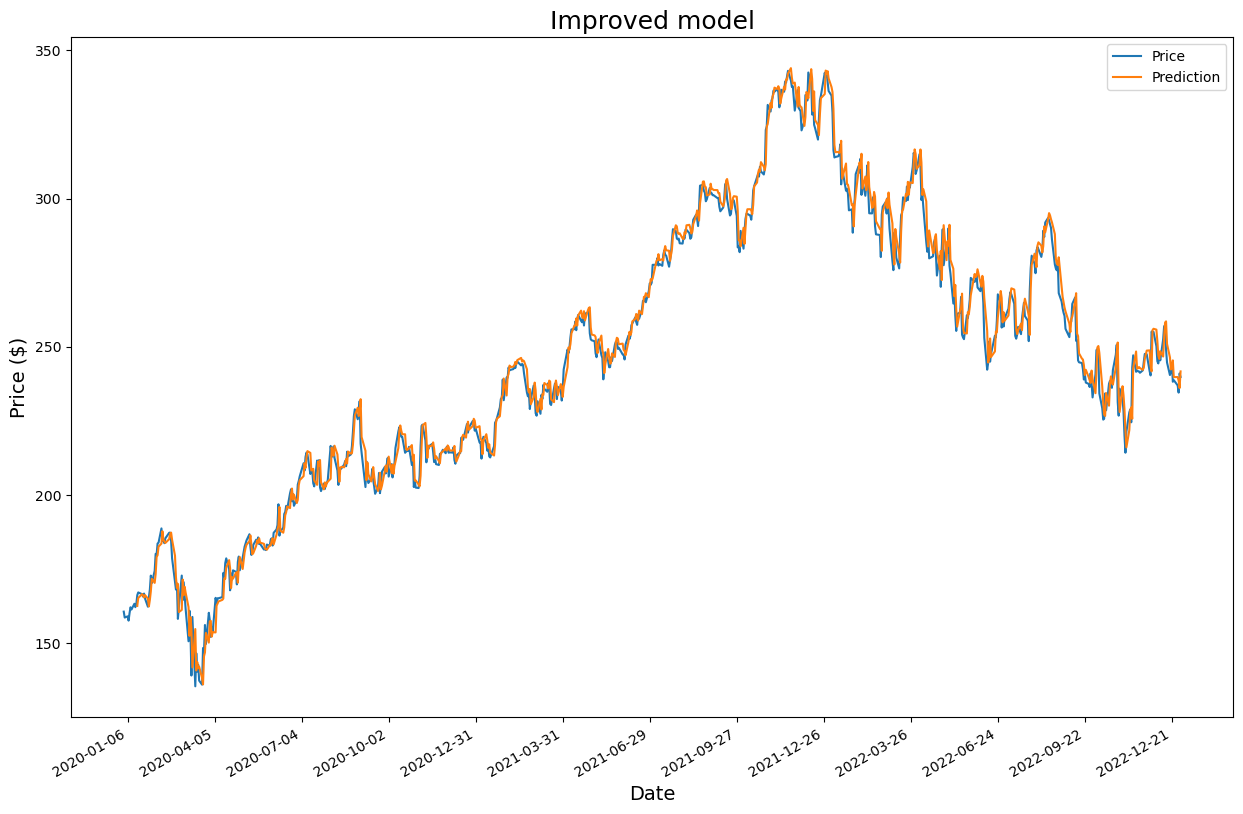

In [19]:
plt.figure(figsize=(15, 10))
plt.gca().xaxis.set_major_formatter(m_dates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(m_dates.DayLocator(interval=90))

plt.title('Improved model', fontsize=18)
plt.plot(test_dates_str, test_price['Close'], label='Price')
plt.plot(test_dates_str[10:], predictions_4, label='Prediction')

plt.xlabel('Date', fontsize=14)
plt.ylabel('Price ($)', fontsize=14)

plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

Makinng models with additional parameters

Model with volumes

Epoch 1/500
42/42 [==============================] - 11s 205ms/step - loss: 0.0029
Epoch 2/500
42/42 [==============================] - 9s 212ms/step - loss: 1.0423e-04
Epoch 3/500
42/42 [==============================] - 9s 212ms/step - loss: 1.0316e-04
Epoch 4/500
42/42 [==============================] - 9s 209ms/step - loss: 8.5421e-05
Epoch 5/500
42/42 [==============================] - 8s 200ms/step - loss: 9.9408e-05
Epoch 6/500
42/42 [==============================] - 9s 208ms/step - loss: 1.1317e-04
Epoch 7/500
42/42 [==============================] - 9s 205ms/step - loss: 1.2183e-04
Epoch 8/500
42/42 [==============================] - 9s 206ms/step - loss: 1.1150e-04
Epoch 9/500
42/42 [==============================] - 9s 206ms/step - loss: 1.0798e-04
Epoch 10/500
42/42 [==============================] - 9s 205ms/step - loss: 1.0912e-04
Epoch 11/500
42/42 [==============================] - 9s 210ms/step - loss: 1.0898e-04
Epoch 12/500
42/42 [==============================] - 9

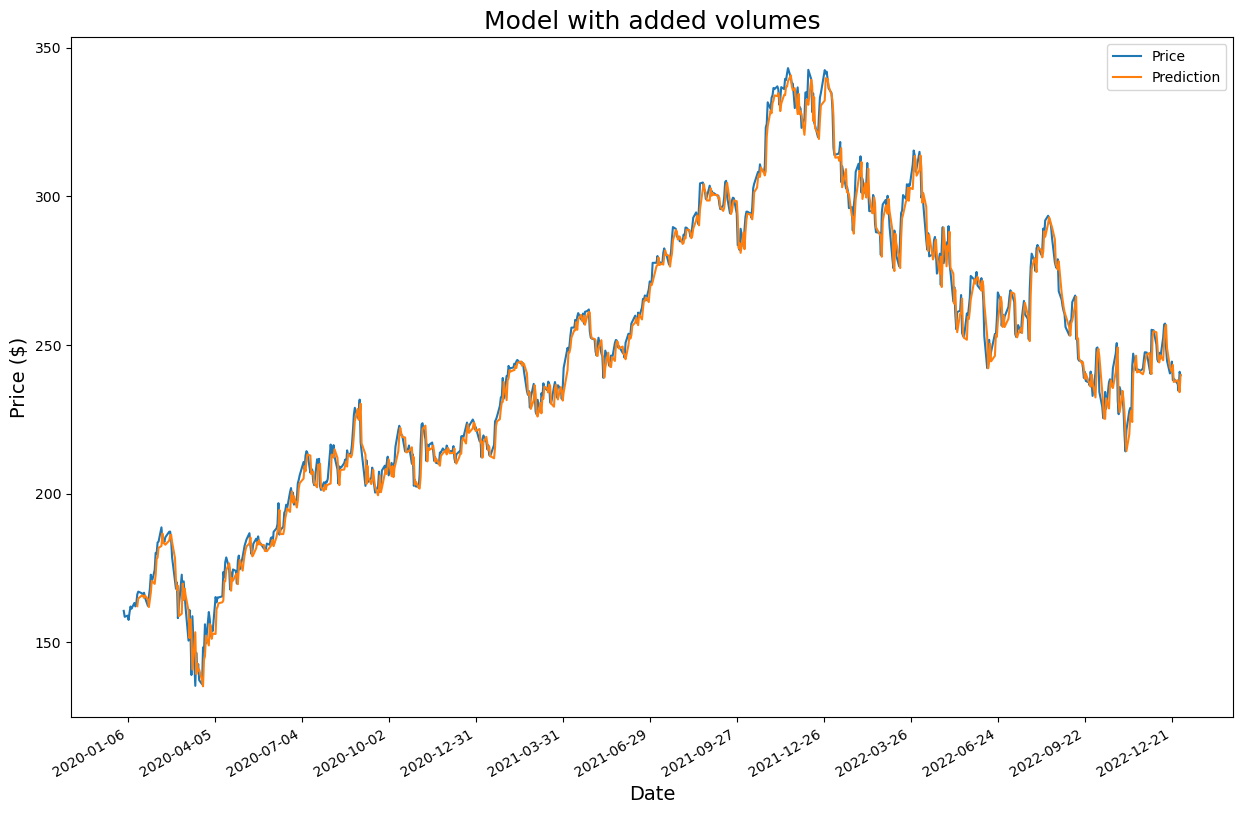

In [20]:
dataset = pd.read_csv(
    filepath_or_buffer='https://raw.githubusercontent.com/Patryk0990/biai-stock-market/main/DATA/historical/AAPL.csv', 
    index_col='Date')

scaler_close = MinMaxScaler(feature_range=(0, 1))
scaler_volume = MinMaxScaler(feature_range=(0, 1))
train_data_close = scaler_close.fit_transform(dataset.filter(['Close']).values)
train_data_volume = scaler_close.fit_transform(dataset.filter(['Volume']).values)

x_train = []
y_train = []

for index in range(10, len(dataset)):
    x_train.append(np.concatenate((train_data_close[index-10:index], train_data_volume[index-10:index]), axis=1))
    y_train.append(train_data_close[index])

# Convert trainset to array and reshape x_train data    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 2))

lstm = Sequential(
    layers=[
        LSTM(512, return_sequences=True, input_shape=(x_train.shape[1], 2)),
        LSTM(256, return_sequences=True),
        LSTM(128),
        Dense(25),
        Dense(1)
    ]
)
lstm.compile(optimizer='adam', loss='mean_squared_error')
lstm.fit(x_train, y_train, batch_size=256, epochs=500)

test_dataset = pd.read_csv(
    filepath_or_buffer='https://raw.githubusercontent.com/Patryk0990/biai-stock-market/main/DATA/three_years/MSFT.csv', 
    index_col='Date')
test_dates_str = [dt.datetime.strptime(d, '%Y-%m-%d').date() for d in test_dataset.index.values]

test_data_close = scaler_close.fit_transform(test_dataset.filter(['Close']).values)
test_data_volume = scaler_volume.fit_transform(test_dataset.filter(['Volume']).values)

x_test = []
y_test = test_dataset.filter(['Close']).values[10:len(test_dataset)]

for index in range(10, len(test_data_close)):
    x_test.append(np.concatenate((test_data_close[index-10:index], test_data_volume[index-10:index]), axis=1))
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 2))

predictions = lstm.predict(x_test)
predictions = scaler_close.inverse_transform(predictions)
rmse=np.sqrt(np.mean((predictions - y_test) ** 2))
print(f'RMSE: {rmse}')

plt.figure(figsize=(15, 10))
plt.gca().xaxis.set_major_formatter(m_dates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(m_dates.DayLocator(interval=90))

plt.title('Model with added volumes', fontsize=18)
plt.plot(test_dates_str, test_dataset['Close'], label='Price')
plt.plot(test_dates_str[10:], predictions, label='Prediction')

plt.xlabel('Date', fontsize=14)
plt.ylabel('Price ($)', fontsize=14)

plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

Model with RSI

Epoch 1/500
42/42 [==============================] - 12s 208ms/step - loss: 0.0044
Epoch 2/500
42/42 [==============================] - 8s 201ms/step - loss: 1.5256e-04
Epoch 3/500
42/42 [==============================] - 9s 208ms/step - loss: 8.4980e-05
Epoch 4/500
42/42 [==============================] - 9s 204ms/step - loss: 9.9642e-05
Epoch 5/500
42/42 [==============================] - 9s 204ms/step - loss: 9.3201e-05
Epoch 6/500
42/42 [==============================] - 9s 208ms/step - loss: 8.2823e-05
Epoch 7/500
42/42 [==============================] - 8s 202ms/step - loss: 9.6889e-05
Epoch 8/500
42/42 [==============================] - 9s 209ms/step - loss: 9.0682e-05
Epoch 9/500
42/42 [==============================] - 8s 202ms/step - loss: 1.0489e-04
Epoch 10/500
42/42 [==============================] - 9s 208ms/step - loss: 9.0130e-05
Epoch 11/500
42/42 [==============================] - 9s 205ms/step - loss: 8.7360e-05
Epoch 12/500
42/42 [==============================] - 9

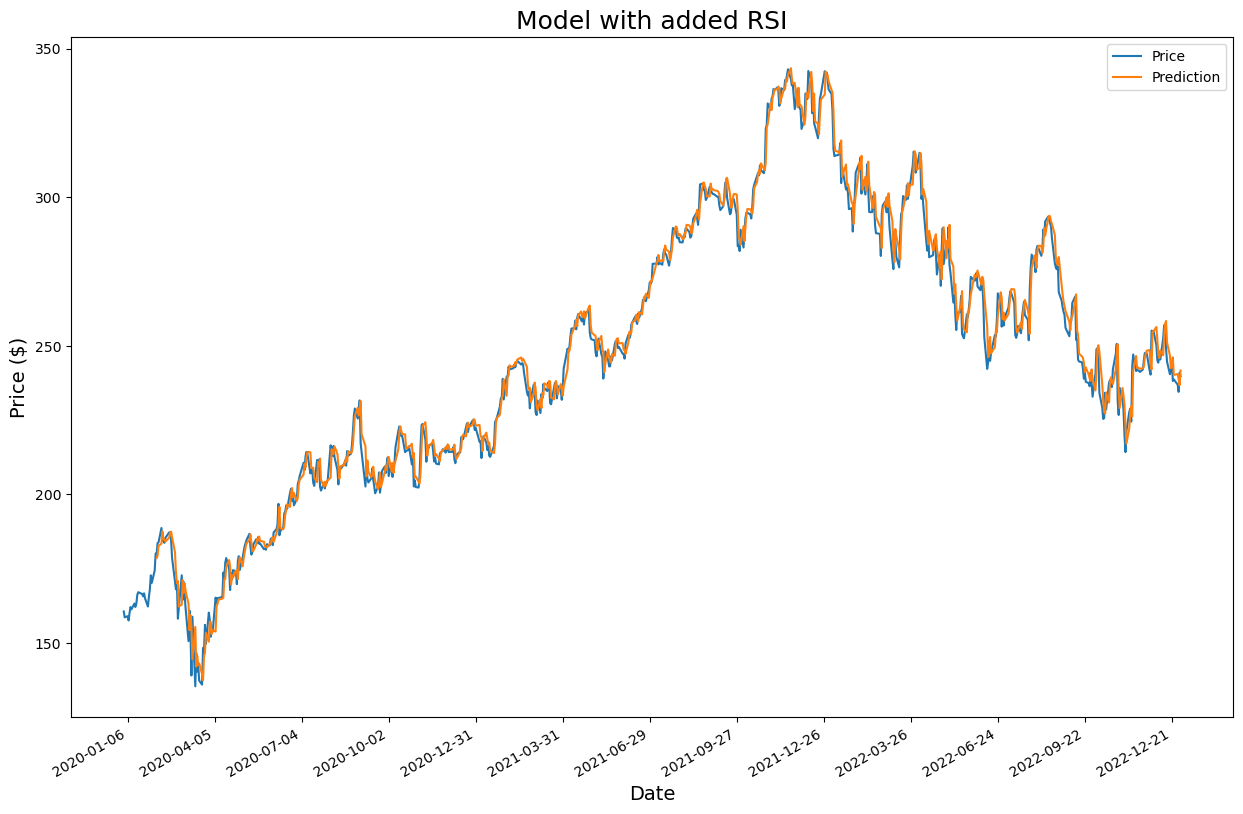

In [21]:
dataset = pd.read_csv(
    filepath_or_buffer='https://raw.githubusercontent.com/Patryk0990/biai-stock-market/main/DATA/historical/AAPL.csv', 
    index_col='Date')

delta = dataset['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14, min_periods=14).mean()
avg_loss = loss.rolling(window=14, min_periods=14).mean().abs()
rs = avg_gain / avg_loss
rsi = 100 - (100 / (1 + rs))
rsi = rsi.iloc[13:]

dataset = dataset.iloc[13:]

scaler_close = MinMaxScaler(feature_range=(0, 1))
scaler_rsi = MinMaxScaler(feature_range=(0, 1))
train_data_close = scaler_close.fit_transform(dataset.filter(['Close']).values)
train_data_rsi = scaler_close.fit_transform(rsi.values.reshape(-1, 1))

x_train = []
y_train = []

for index in range(10, len(dataset)):
    x_train.append(
        np.concatenate(
            (
                train_data_close[index-10:index], 
                train_data_rsi[index-10:index]
            ), 
            axis=1,
        )
    )
    y_train.append(train_data_close[index])

# Convert trainset to array and reshape x_train data    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 2))

lstm = Sequential(
    layers=[
        LSTM(512, return_sequences=True, input_shape=(x_train.shape[1], 2)),
        LSTM(256, return_sequences=True),
        LSTM(128),
        Dense(25),
        Dense(1)
    ]
)
lstm.compile(optimizer='adam', loss='mean_squared_error')
lstm.fit(x_train, y_train, batch_size=256, epochs=500)

test_dataset = pd.read_csv(
    filepath_or_buffer='https://raw.githubusercontent.com/Patryk0990/biai-stock-market/main/DATA/three_years/MSFT.csv', 
    index_col='Date')

test_delta = dataset['Close'].diff()
test_gain = delta.where(delta > 0, 0)
test_loss = -delta.where(delta < 0, 0)
test_avg_gain = gain.rolling(window=14, min_periods=14).mean()
test_avg_loss = loss.rolling(window=14, min_periods=14).mean().abs()
test_rs = avg_gain / avg_loss
test_rsi = 100 - (100 / (1 + rs))
test_rsi = test_rsi.iloc[13:]

test_dates_str = [dt.datetime.strptime(d, '%Y-%m-%d').date() for d in test_dataset.index.values]
test_data_close = scaler_close.fit_transform(test_dataset.iloc[13:].filter(['Close']).values)
test_data_rsi = scaler_rsi.fit_transform(test_rsi.values.reshape(-1, 1))

x_test = []
y_test = test_dataset.filter(['Close']).values[23:len(test_dataset)]

for index in range(10, len(test_data_close)):
    x_test.append(
        np.concatenate(
            (
                test_data_close[index-10:index], 
                test_data_rsi[index-10:index],
            ), 
            axis=1
        )
    )


x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 2))

predictions = lstm.predict(x_test)
predictions = scaler_close.inverse_transform(predictions)
rmse=np.sqrt(np.mean((predictions - y_test) ** 2))
print(f'RMSE: {rmse}')

plt.figure(figsize=(15, 10))
plt.gca().xaxis.set_major_formatter(m_dates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(m_dates.DayLocator(interval=90))

plt.title('Model with added RSI', fontsize=18)
plt.plot(test_dates_str, test_dataset['Close'], label='Price')
plt.plot(test_dates_str[23:], predictions, label='Prediction')

plt.xlabel('Date', fontsize=14)
plt.ylabel('Price ($)', fontsize=14)

plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

Model with MACD

Epoch 1/500
42/42 [==============================] - 12s 210ms/step - loss: 0.0072
Epoch 2/500
42/42 [==============================] - 9s 211ms/step - loss: 1.3013e-04
Epoch 3/500
42/42 [==============================] - 9s 211ms/step - loss: 8.7041e-05
Epoch 4/500
42/42 [==============================] - 9s 218ms/step - loss: 8.1763e-05
Epoch 5/500
42/42 [==============================] - 9s 224ms/step - loss: 9.5752e-05
Epoch 6/500
42/42 [==============================] - 9s 208ms/step - loss: 8.5598e-05
Epoch 7/500
42/42 [==============================] - 9s 226ms/step - loss: 8.7678e-05
Epoch 8/500
42/42 [==============================] - 9s 210ms/step - loss: 1.0393e-04
Epoch 9/500
42/42 [==============================] - 9s 216ms/step - loss: 9.3951e-05
Epoch 10/500
42/42 [==============================] - 9s 212ms/step - loss: 8.8179e-05
Epoch 11/500
42/42 [==============================] - 9s 217ms/step - loss: 8.4797e-05
Epoch 12/500
42/42 [==============================] - 9

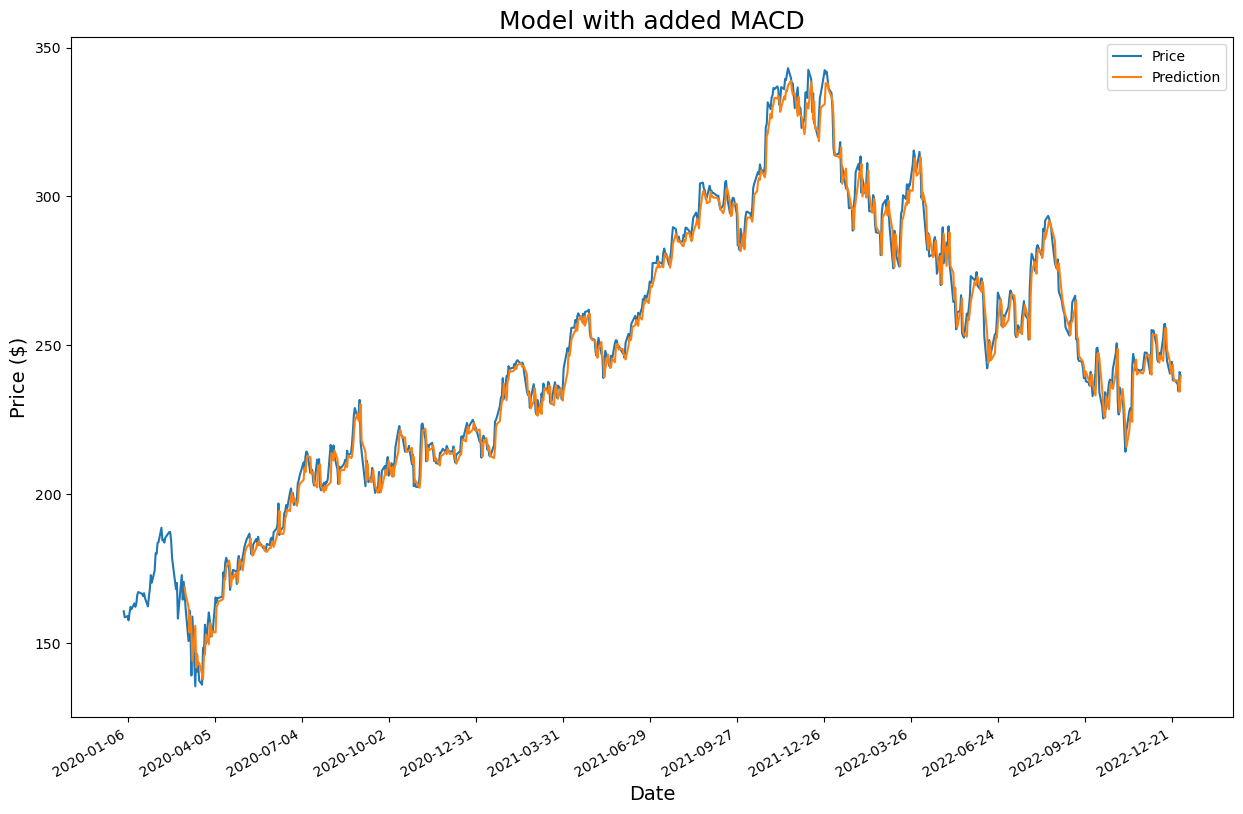

In [22]:
dataset = pd.read_csv(
    filepath_or_buffer='https://raw.githubusercontent.com/Patryk0990/biai-stock-market/main/DATA/historical/AAPL.csv', 
    index_col='Date')

ema_13 = dataset['Close'].ewm(span=13, min_periods=13, adjust=False).mean()
ema_26 = dataset['Close'].ewm(span=26, min_periods=26, adjust=False).mean()
macd = ema_13 - ema_26
macd_trigger = macd.ewm(span=9, min_periods=9, adjust=False).mean().iloc[33:]
macd = macd[33:]
macd_difference = macd - macd_trigger

dataset = dataset.iloc[33:]

scaler_close = MinMaxScaler(feature_range=(0, 1))
scaler_macd = MinMaxScaler(feature_range=(0, 1))
scaler_macd_trigger = MinMaxScaler(feature_range=(0, 1))
scaler_macd_difference = MinMaxScaler(feature_range=(0, 1))
train_data_close = scaler_close.fit_transform(dataset.filter(['Close']).values)
train_data_macd = scaler_macd.fit_transform(macd.values.reshape(-1, 1))
train_data_macd_trigger = scaler_macd_trigger.fit_transform(macd_trigger.values.reshape(-1, 1))
train_data_macd_difference = scaler_macd_difference.fit_transform(macd_difference.values.reshape(-1, 1))

x_train = []
y_train = []

for index in range(10, len(dataset)):
    x_train.append(
        np.concatenate(
            (
                train_data_close[index-10:index], 
                train_data_macd[index-10:index],
                train_data_macd_trigger[index-10:index],
                train_data_macd_difference[index-10:index],
            ), 
            axis=1,
        )
    )
    y_train.append(train_data_close[index])

# Convert trainset to array and reshape x_train data    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 4))

lstm = Sequential(
    layers=[
        LSTM(512, return_sequences=True, input_shape=(x_train.shape[1], 4)),
        LSTM(256, return_sequences=True),
        LSTM(128),
        Dense(25),
        Dense(1)
    ]
)
lstm.compile(optimizer='adam', loss='mean_squared_error')
lstm.fit(x_train, y_train, batch_size=256, epochs=500)

test_dataset = pd.read_csv(
    filepath_or_buffer='https://raw.githubusercontent.com/Patryk0990/biai-stock-market/main/DATA/three_years/MSFT.csv', 
    index_col='Date')

test_ema_13 = test_dataset['Close'].ewm(span=13, min_periods=13, adjust=False).mean()
test_ema_26 = test_dataset['Close'].ewm(span=26, min_periods=26, adjust=False).mean()
test_macd = test_ema_13 - test_ema_26
test_macd_trigger = test_macd.ewm(span=9, min_periods=9, adjust=False).mean().iloc[33:]
test_macd = test_macd.iloc[33:]
test_macd_difference = test_macd - test_macd_trigger

test_dates_str = [dt.datetime.strptime(d, '%Y-%m-%d').date() for d in test_dataset.index.values]

test_data_close = scaler_close.fit_transform(test_dataset.iloc[33:].filter(['Close']).values)
test_data_macd = scaler_macd.fit_transform(test_macd.values.reshape(-1, 1))
test_data_macd_trigger = scaler_macd_trigger.fit_transform(test_macd_trigger.values.reshape(-1, 1))
test_data_macd_difference = scaler_macd_difference.fit_transform(test_macd_difference.values.reshape(-1, 1))

x_test = []
y_test = test_dataset.filter(['Close']).values[43:len(test_dataset)]

for index in range(10, len(test_data_close)):
    x_test.append(
        np.concatenate(
            (
                test_data_close[index-10:index], 
                test_data_macd[index-10:index],
                test_data_macd_trigger[index-10:index],
                test_data_macd_difference[index-10:index],
            ), 
            axis=1,
        )
    )
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 4))

predictions = lstm.predict(x_test)
predictions = scaler_close.inverse_transform(predictions)
rmse=np.sqrt(np.mean((predictions - y_test) ** 2))
print(f'RMSE: {rmse}')

plt.figure(figsize=(15, 10))
plt.gca().xaxis.set_major_formatter(m_dates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(m_dates.DayLocator(interval=90))

plt.title('Model with added MACD', fontsize=18)
plt.plot(test_dates_str, test_dataset['Close'], label='Price')
plt.plot(test_dates_str[43:], predictions, label='Prediction')

plt.xlabel('Date', fontsize=14)
plt.ylabel('Price ($)', fontsize=14)

plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

Model with EMA

Epoch 1/500
41/41 [==============================] - 10s 161ms/step - loss: 0.0020
Epoch 2/500
41/41 [==============================] - 7s 163ms/step - loss: 9.0407e-05
Epoch 3/500
41/41 [==============================] - 7s 162ms/step - loss: 8.3969e-05
Epoch 4/500
41/41 [==============================] - 7s 161ms/step - loss: 1.1557e-04
Epoch 5/500
41/41 [==============================] - 7s 162ms/step - loss: 1.0202e-04
Epoch 6/500
41/41 [==============================] - 7s 162ms/step - loss: 8.6339e-05
Epoch 7/500
41/41 [==============================] - 7s 162ms/step - loss: 1.0165e-04
Epoch 8/500
41/41 [==============================] - 7s 162ms/step - loss: 1.7250e-04
Epoch 9/500
41/41 [==============================] - 7s 162ms/step - loss: 1.9834e-04
Epoch 10/500
41/41 [==============================] - 7s 162ms/step - loss: 1.2611e-04
Epoch 11/500
41/41 [==============================] - 7s 162ms/step - loss: 1.2800e-04
Epoch 12/500
41/41 [==============================] - 7

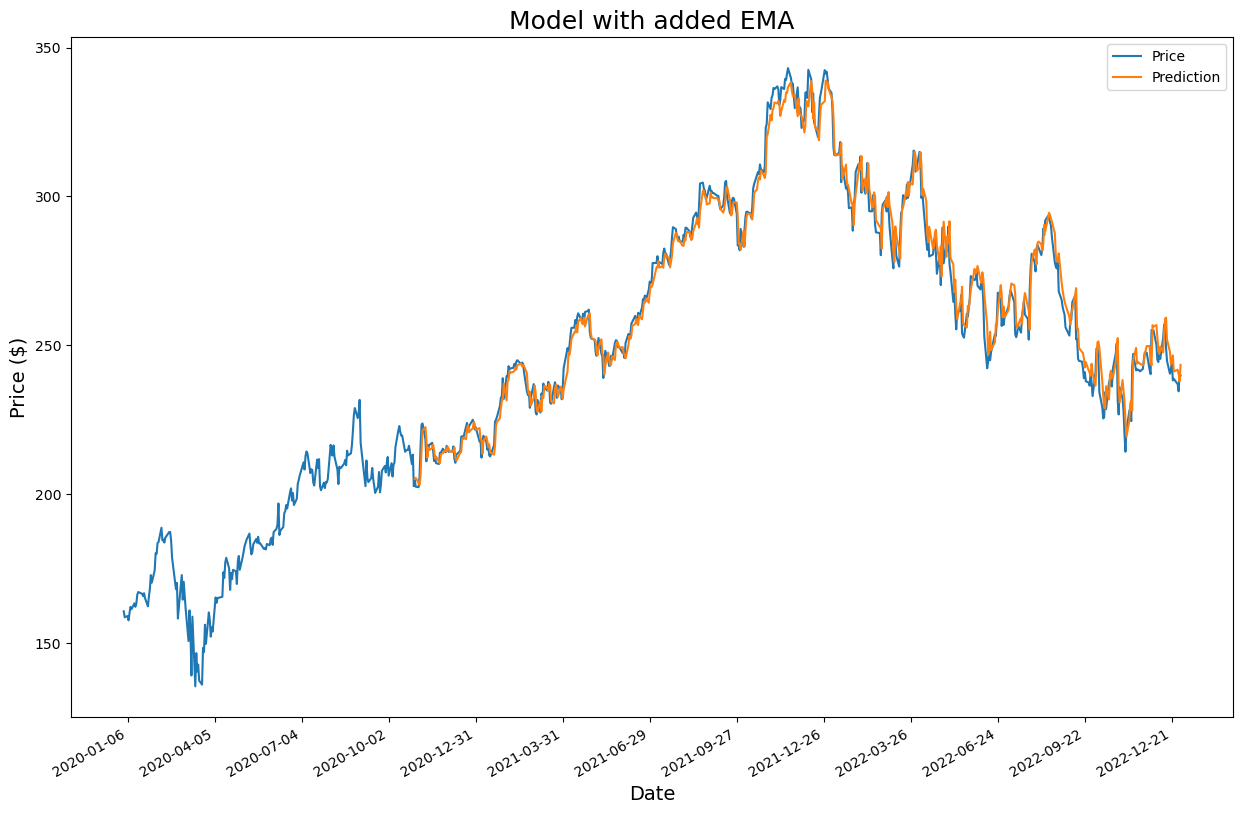

In [2]:
dataset = pd.read_csv(
    filepath_or_buffer='https://raw.githubusercontent.com/Patryk0990/biai-stock-market/main/DATA/historical/AAPL.csv', 
    index_col='Date')

ema_9 = dataset['Close'].ewm(span=9, min_periods=9, adjust=False).mean().iloc[199:]
ema_13 = dataset['Close'].ewm(span=13, min_periods=13, adjust=False).mean().iloc[199:]
ema_26 = dataset['Close'].ewm(span=26, min_periods=26, adjust=False).mean().iloc[199:]
ema_50 = dataset['Close'].ewm(span=50, min_periods=50, adjust=False).mean().iloc[199:]
ema_200 = dataset['Close'].ewm(span=200, min_periods=200, adjust=False).mean().iloc[199:]

scaler_close = MinMaxScaler(feature_range=(0, 1))
scaler_ema_9 = MinMaxScaler(feature_range=(0, 1))
scaler_ema_13 = MinMaxScaler(feature_range=(0, 1))
scaler_ema_26 = MinMaxScaler(feature_range=(0, 1))
scaler_ema_50 = MinMaxScaler(feature_range=(0, 1))
scaler_ema_200 = MinMaxScaler(feature_range=(0, 1))
train_data_close = scaler_close.fit_transform(dataset.filter(['Close']).values)
train_data_ema_9 = scaler_ema_9.fit_transform(ema_9.values.reshape(-1, 1))
train_data_ema_13 = scaler_ema_13.fit_transform(ema_13.values.reshape(-1, 1))
train_data_ema_26 = scaler_ema_26.fit_transform(ema_26.values.reshape(-1, 1))
train_data_ema_50 = scaler_ema_50.fit_transform(ema_50.values.reshape(-1, 1))
train_data_ema_200 = scaler_ema_200.fit_transform(ema_200.values.reshape(-1, 1))

dataset = dataset.iloc[199:]

x_train = []
y_train = []

for index in range(10, len(dataset)):
    x_train.append(
        np.concatenate(
            (
                train_data_close[index-10:index], 
                train_data_ema_9[index-10:index],
                train_data_ema_13[index-10:index],
                train_data_ema_26[index-10:index],
                train_data_ema_50[index-10:index],
                train_data_ema_200[index-10:index],
            ), 
            axis=1,
        )
    )
    y_train.append(train_data_close[index])

# Convert trainset to array and reshape x_train data    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 6))

lstm = Sequential(
    layers=[
        LSTM(512, return_sequences=True, input_shape=(x_train.shape[1], 6)),
        LSTM(256, return_sequences=True),
        LSTM(128),
        Dense(25),
        Dense(1)
    ]
)
lstm.compile(optimizer='adam', loss='mean_squared_error')
lstm.fit(x_train, y_train, batch_size=256, epochs=500)

test_dataset = pd.read_csv(
    filepath_or_buffer='https://raw.githubusercontent.com/Patryk0990/biai-stock-market/main/DATA/three_years/MSFT.csv', 
    index_col='Date')

test_ema_9 = test_dataset['Close'].ewm(span=9, min_periods=9, adjust=False).mean().iloc[199:]
test_ema_13 = test_dataset['Close'].ewm(span=13, min_periods=13, adjust=False).mean().iloc[199:]
test_ema_26 = test_dataset['Close'].ewm(span=26, min_periods=26, adjust=False).mean().iloc[199:]
test_ema_50 = test_dataset['Close'].ewm(span=50, min_periods=50, adjust=False).mean().iloc[199:]
test_ema_200 = test_dataset['Close'].ewm(span=200, min_periods=200, adjust=False).mean().iloc[199:]

test_data_close = scaler_close.fit_transform(test_dataset.iloc[199:].filter(['Close']).values)
test_data_ema_9 = scaler_ema_9.fit_transform(test_ema_9.values.reshape(-1, 1))
test_data_ema_13 = scaler_ema_13.fit_transform(test_ema_13.values.reshape(-1, 1))
test_data_ema_26 = scaler_ema_26.fit_transform(test_ema_26.values.reshape(-1, 1))
test_data_ema_50 = scaler_ema_50.fit_transform(test_ema_50.values.reshape(-1, 1))
test_data_ema_200 = scaler_ema_200.fit_transform(test_ema_200.values.reshape(-1, 1))

test_dates_str = [dt.datetime.strptime(d, '%Y-%m-%d').date() for d in test_dataset.index.values]

x_test = []
y_test = test_dataset.filter(['Close']).values[209:len(test_dataset)]

for index in range(10, len(test_data_close)):
    x_test.append(
        np.concatenate(
            (
                test_data_close[index-10:index], 
                test_data_ema_9[index-10:index],
                test_data_ema_13[index-10:index],
                test_data_ema_26[index-10:index],
                test_data_ema_50[index-10:index],
                test_data_ema_200[index-10:index],
            ), 
            axis=1,
        )
    )
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 6))

predictions = lstm.predict(x_test)
predictions = scaler_close.inverse_transform(predictions)
rmse=np.sqrt(np.mean((predictions - y_test) ** 2))
print(f'RMSE: {rmse}')

plt.figure(figsize=(15, 10))
plt.gca().xaxis.set_major_formatter(m_dates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(m_dates.DayLocator(interval=90))

plt.title('Model with added EMA', fontsize=18)
plt.plot(test_dates_str, test_dataset['Close'], label='Price')
plt.plot(test_dates_str[209:], predictions, label='Prediction')

plt.xlabel('Date', fontsize=14)
plt.ylabel('Price ($)', fontsize=14)

plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

Model with choosen few of previous parameters

Epoch 1/500
42/42 [==============================] - 10s 167ms/step - loss: 0.0059
Epoch 2/500
42/42 [==============================] - 8s 189ms/step - loss: 1.9631e-04
Epoch 3/500
42/42 [==============================] - 8s 183ms/step - loss: 1.1641e-04
Epoch 4/500
42/42 [==============================] - 7s 167ms/step - loss: 1.1282e-04
Epoch 5/500
42/42 [==============================] - 7s 167ms/step - loss: 1.1066e-04
Epoch 6/500
42/42 [==============================] - 7s 167ms/step - loss: 9.4490e-05
Epoch 7/500
42/42 [==============================] - 7s 166ms/step - loss: 1.1227e-04
Epoch 8/500
42/42 [==============================] - 7s 167ms/step - loss: 8.6710e-05
Epoch 9/500
42/42 [==============================] - 7s 166ms/step - loss: 8.8429e-05
Epoch 10/500
42/42 [==============================] - 7s 165ms/step - loss: 7.9406e-05
Epoch 11/500
42/42 [==============================] - 7s 166ms/step - loss: 8.4443e-05
Epoch 12/500
42/42 [==============================] - 7

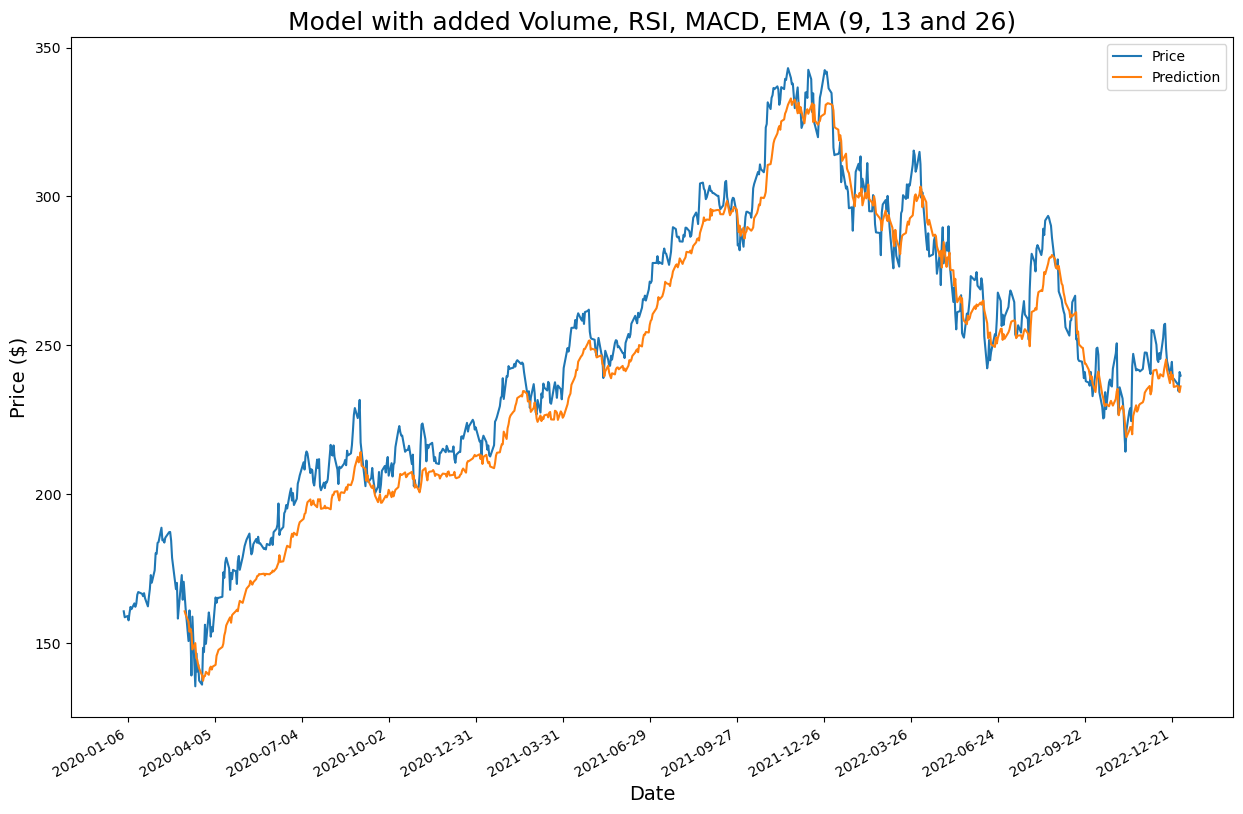

In [3]:
dataset = pd.read_csv(
    filepath_or_buffer='https://raw.githubusercontent.com/Patryk0990/biai-stock-market/main/DATA/historical/AAPL.csv', 
    index_col='Date')

delta = dataset['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14, min_periods=14).mean()
avg_loss = loss.rolling(window=14, min_periods=14).mean().abs()
rs = avg_gain / avg_loss
rsi = 100 - (100 / (1 + rs))
rsi = rsi.iloc[33:]

ema_9 = dataset['Close'].ewm(span=9, min_periods=9, adjust=False).mean()
ema_13 = dataset['Close'].ewm(span=13, min_periods=13, adjust=False).mean()
ema_26 = dataset['Close'].ewm(span=26, min_periods=26, adjust=False).mean()

macd = ema_13 - ema_26
macd_trigger = macd.ewm(span=9, min_periods=9, adjust=False).mean().iloc[33:]
macd = macd[33:]
macd_difference = macd - macd_trigger
ema_9 = ema_9.iloc[33:]
ema_13 = ema_13.iloc[33:]
ema_26 = ema_26.iloc[33:]

dataset = dataset.iloc[33:]

scaler_close = MinMaxScaler(feature_range=(0, 1))
scaler_volume = MinMaxScaler(feature_range=(0, 1))
scaler_rsi = MinMaxScaler(feature_range=(0, 1))
scaler_ema_9 = MinMaxScaler(feature_range=(0, 1))
scaler_ema_13 = MinMaxScaler(feature_range=(0, 1))
scaler_ema_26 = MinMaxScaler(feature_range=(0, 1))
scaler_macd = MinMaxScaler(feature_range=(0, 1))
scaler_macd_trigger = MinMaxScaler(feature_range=(0, 1))
scaler_macd_difference = MinMaxScaler(feature_range=(0, 1))

train_data_close = scaler_close.fit_transform(dataset.filter(['Close']).values)
train_data_volume = scaler_volume.fit_transform(dataset.filter(['Volume']).values)
train_data_rsi = scaler_rsi.fit_transform(rsi.values.reshape(-1, 1))
train_data_ema_9 = scaler_ema_9.fit_transform(ema_9.values.reshape(-1, 1))
train_data_ema_13 = scaler_ema_13.fit_transform(ema_13.values.reshape(-1, 1))
train_data_ema_26 = scaler_ema_26.fit_transform(ema_26.values.reshape(-1, 1))
train_data_macd = scaler_macd.fit_transform(macd.values.reshape(-1, 1))
train_data_macd_trigger = scaler_macd_trigger.fit_transform(macd_trigger.values.reshape(-1, 1))
train_data_macd_difference = scaler_macd_difference.fit_transform(macd_difference.values.reshape(-1, 1))

x_train = []
y_train = []

for index in range(10, len(dataset)):
    x_train.append(
        np.concatenate(
            (
                train_data_close[index-10:index],
                train_data_volume[index-10:index],
                train_data_rsi[index-10:index], 
                train_data_ema_9[index-10:index],
                train_data_ema_13[index-10:index],
                train_data_ema_26[index-10:index],
                train_data_macd[index-10:index],
                train_data_macd_trigger[index-10:index],
                train_data_macd_difference[index-10:index],
            ), 
            axis=1,
        )
    )
    y_train.append(train_data_close[index])

# Convert trainset to array and reshape x_train data    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 9))

lstm = Sequential(
    layers=[
        LSTM(512, return_sequences=True, input_shape=(x_train.shape[1], 9)),
        LSTM(256, return_sequences=True),
        LSTM(128),
        Dense(25),
        Dense(1)
    ]
)
lstm.compile(optimizer='adam', loss='mean_squared_error')
lstm.fit(x_train, y_train, batch_size=256, epochs=500)

test_dataset = pd.read_csv(
    filepath_or_buffer='https://raw.githubusercontent.com/Patryk0990/biai-stock-market/main/DATA/three_years/MSFT.csv', 
    index_col='Date')

test_delta = dataset['Close'].diff()
test_gain = delta.where(delta > 0, 0)
test_loss = -delta.where(delta < 0, 0)
test_avg_gain = gain.rolling(window=14, min_periods=14).mean()
test_avg_loss = loss.rolling(window=14, min_periods=14).mean().abs()
test_rs = avg_gain / avg_loss
test_rsi = 100 - (100 / (1 + rs))
test_rsi = test_rsi.iloc[33:]

test_ema_9 = test_dataset['Close'].ewm(span=9, min_periods=9, adjust=False).mean()
test_ema_13 = test_dataset['Close'].ewm(span=13, min_periods=13, adjust=False).mean()
test_ema_26 = test_dataset['Close'].ewm(span=26, min_periods=26, adjust=False).mean()

test_macd = ema_13 - ema_26
test_macd_trigger = test_macd.ewm(span=9, min_periods=9, adjust=False).mean().iloc[33:]
test_macd = test_macd[33:]
test_macd_difference = test_macd - test_macd_trigger
test_ema_9 = test_ema_9.iloc[33:]
test_ema_13 = test_ema_13.iloc[33:]
test_ema_26 = test_ema_26.iloc[33:]

test_dates_str = [dt.datetime.strptime(d, '%Y-%m-%d').date() for d in test_dataset.index.values]
test_data_close = scaler_close.fit_transform(test_dataset.iloc[33:].filter(['Close']).values)
test_data_volume = scaler_volume.fit_transform(test_dataset.iloc[33:].filter(['Volume']).values)
test_data_rsi = scaler_rsi.fit_transform(test_rsi.values.reshape(-1, 1))
test_data_ema_9 = scaler_ema_9.fit_transform(test_ema_9.values.reshape(-1, 1))
test_data_ema_13 = scaler_ema_13.fit_transform(test_ema_13.values.reshape(-1, 1))
test_data_ema_26 = scaler_ema_26.fit_transform(test_ema_26.values.reshape(-1, 1))
test_data_macd = scaler_macd.fit_transform(test_macd.values.reshape(-1, 1))
test_data_macd_trigger = scaler_macd_trigger.fit_transform(test_macd_trigger.values.reshape(-1, 1))
test_data_macd_difference = scaler_macd_difference.fit_transform(test_macd_difference.values.reshape(-1, 1))

x_test = []
y_test = test_dataset.filter(['Close']).values[43:len(test_dataset)]

for index in range(10, len(test_data_close)):
    x_test.append(
        np.concatenate(
            (
                test_data_close[index-10:index],
                test_data_volume[index-10:index],
                test_data_rsi[index-10:index],  
                test_data_ema_9[index-10:index],
                test_data_ema_13[index-10:index],
                test_data_ema_26[index-10:index],
                test_data_macd[index-10:index],
                test_data_macd_trigger[index-10:index],
                test_data_macd_difference[index-10:index],
            ), 
            axis=1,
        )
    )
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 9))

predictions = lstm.predict(x_test)
predictions = scaler_close.inverse_transform(predictions)
rmse=np.sqrt(np.mean((predictions - y_test) ** 2))
print(f'RMSE: {rmse}')

plt.figure(figsize=(15, 10))
plt.gca().xaxis.set_major_formatter(m_dates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(m_dates.DayLocator(interval=90))

plt.title('Model with added Volume, RSI, MACD, EMA (9, 13 and 26)', fontsize=18)
plt.plot(test_dates_str, test_dataset['Close'], label='Price')
plt.plot(test_dates_str[43:], predictions, label='Prediction')

plt.xlabel('Date', fontsize=14)
plt.ylabel('Price ($)', fontsize=14)

plt.legend()
plt.gcf().autofmt_xdate()
plt.show()